In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os, time, math, warnings
warnings.filterwarnings('ignore')
import polcal_lib_v2 as pln
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#pln.lm_test(njacobian=True,limits = np.array([[0,0.1,0.3],[1,1.4,4.3]]))

### Generating a set of calibration units states
*cal_unit* takes as arguments: [alpha, delta, theta] where

-    alpha == off set of the polarizer(angle)
-    delta == retardance of retarder
-    theta == off set of the retarder 

In [3]:
pardata = {'delta1' : np.array([225., 225., 315., 315.]),
           'delta2' : np.array([234., 125.26, 54.74, 305.26]),
           'theta1' : 0.0,
           'theta2' : 45.0,
           'pol_angle' : 0.0,
           'rot_inst' : 0.0}

mod_matrix = pln.instrument_model(pardata=pardata)
print(2.*mod_matrix)

[[ 1.         -0.58778525  0.5720614  -0.5720614 ]
 [ 1.         -0.57728771 -0.57738155  0.57738155]
 [ 1.          0.57728771 -0.57738155 -0.57738155]
 [ 1.          0.57728771  0.57738155  0.57738155]]


In [4]:
cl = pln.cal_unit(-0.305, 75.442, 0., angle_rot=None)
#result is a column vector!
print(cl)


[[ 0.5       ]
 [ 0.49997166]
 [-0.00133803]
 [ 0.00515225]]


If you want to generate a full range of calibration states

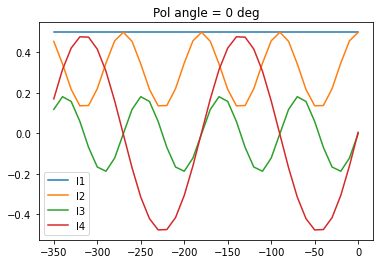

In [5]:
#generate the calibration states (input to instrument)
#def cal_unit(alpha, delta, theta, angle_rot=None):
    #theta = off set of the retarder
    #delta = retardance
    #alpha = off set of the polarizer(angle)
    #theta = np.arange(0, -360, -1)
theta = np.arange(0, -360, -10)
out = np.zeros((4,36))
for i in range(len(theta)):
    out[:,i] = pln.cal_unit(-0.305, 75.442,theta[i]).flatten()
plt.plot(theta, out[0, :], label = 'I1')
plt.plot(theta, out[1, :], label = 'I2')
plt.plot(theta, out[2, :], label = 'I3')
plt.plot(theta, out[3, :], label = 'I4')
plt.title('Pol angle = 0 deg')
plt.legend()
plt.show()


- Instrument model is in pol_model
- input is system parameters (see example below) and rotation angle) 

    #def pol_model(pardata=pardata,angle_rot=0):



In [6]:
pardata = {'delta1' : np.array([225., 225., 315., 315.]),
           'delta2' : np.array([234., 125.26, 54.74, 305.26]),
           'theta1' : 0.0,
           'theta2' : 45.0,
           'pol_angle' : 0.0,
           'rot_inst' : 0.0}

mod_matrix = pln.instrument_model(pardata=pardata)
print(2.*mod_matrix)

[[ 1.         -0.58778525  0.5720614  -0.5720614 ]
 [ 1.         -0.57728771 -0.57738155  0.57738155]
 [ 1.          0.57728771 -0.57738155 -0.57738155]
 [ 1.          0.57728771  0.57738155  0.57738155]]


We can see how the instrument modulates the PCU input

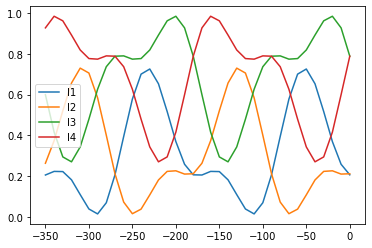

In [7]:
mod_matrix, response = pln.pol_cal_model(pardata,alpha=0, delta=75, theta=np.arange(0, -360, -10),plot=True)

Lets read some data and compare the output with the model

In [8]:
#leemos los datos
from scipy.io.idl import readsav
file = '../../../../PHI_POLCAL_revisited/datos_FDT_40D_J0.sav'
file = '/Volumes/New Volume/PHI_WORK/PHI_POLCAL/data_a.sav'
s = readsav(file)
data = s.data
data = np.einsum('klij->ijkl', data)
#norma = np.max(data[500:1500,500:1500,:,:])
#data = data/norma

In [9]:
#read_signal = np.mean(data[1024-200:1024+200,1024-200:1024+200,:,:],axis=(0,1)) 
read_signal = np.mean(data[500:1747,400:1647,:,:],axis=(0,1)) 
#normalize around the max:
#norma = np.max(data[1024-200:1024+200,1024-200:1024+200,:,:])  
dnorma = np.max(data[500:1747,400:1647,:,:])  
#read_signal /= norma
np.savez('sigma',read_signal)

15676.691


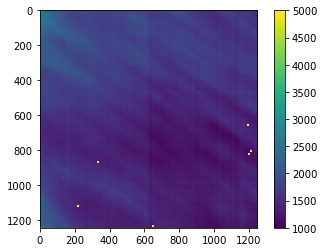

In [10]:
plt.imshow(data[500:1747,400:1647,11,0],vmax=5000,vmin=1000)
plt.colorbar()
print(data[400,500,12,0])

In [11]:
pardata = {'delta1' : np.array([225., 225., 315., 315.]),
           'delta2' : np.array([234., 125.26, 54.74, 305.26]),
           'theta1' : 0.0,
           'theta2' : 45.0,
           'pol_angle' : 0.0,
           'rot_inst' : 0.0}
theta = np.arange(0, -360, -10) #- 0.631 #wave plate fast axis angle
'''
#theta = off set of the retarder
#delta = retardance
#alpha = off set of the polarizer(angle)
'''
#el modelo
#-5.76200
mod_matrix, response = pln.pol_cal_model(pardata,alpha= -0.762, delta=75.519997, theta=theta)

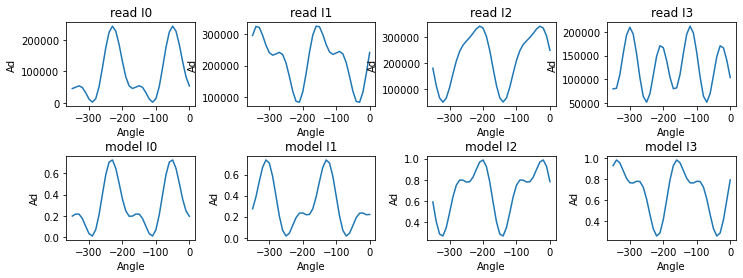

In [12]:
fig, maps = plt.subplots(2,4,figsize=(12,4))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
for i in range(4):
    maps[0,i].plot(theta, read_signal[:,i])
    #maps[0,i].xvline(theta, read_signal[:,i])
    maps[0,i].set_title('read I'+str(i))
    maps[0,i].set_ylabel('Ad')
    maps[0,i].set_xlabel('Angle')
for i in range(4):
    maps[1,i].plot(theta, response[:,i])
    maps[1,i].set_title('model I'+str(i))
    maps[1,i].set_ylabel('Ad')
    maps[1,i].set_xlabel('Angle')

In [13]:
def fit_calib(x,y,plot=None,w_cut=1e-10):
    '''
    input:  calib states (angle,4), obs (angle)
    '''
    xc = np.matmul(x.T,x)
    xi = pln.svd_solve(xc, w_cut=w_cut)
    cf = np.matmul(xi,np.matmul(x.T,y))
    yfit = np.matmul(x,cf)
    cov = np.sqrt(np.sum((yfit - y)**2)/(len(y) - len(xc) + 1.0 ) * xc.diagonal() )
    if plot:
        plt.plot(y,'.')
        plt.plot(yfit,'-')
    return cf,yfit,cov

[[ 0.9981787  -0.68109161  0.39317215 -0.60398663]
 [ 1.00412024  0.43172639  0.71671194  0.55287677]
 [ 0.9972979   0.44578801 -0.38734923 -0.80710388]
 [ 1.00040315 -0.4099361  -0.90405973  0.14139236]]


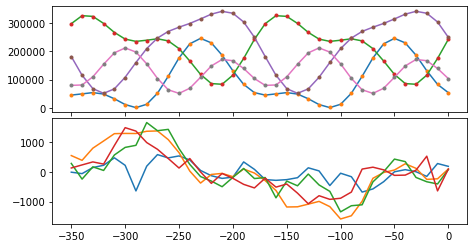

In [14]:
from matplotlib.gridspec import GridSpec

#angulos iniciales para la unidad de calibración 
# que proporciona 36x4 inputs
theta = np.arange(0,-360,-10) 
xdata = np.zeros((36, 4))
for i in range(len(theta)):
    xdata[i,:] = pln.cal_unit(-0.335, 75.519997 ,theta[i] -0.6309999,angle_rot=0).flatten()
#    xdata[i,:] = pln.cal_unit(-0.335,75.442,theta[i],angle_rot=0).flatten()

#datos leidos en el instrumento (36x4 tambien)
ydata = np.copy(read_signal).astype(float)
modm = np.zeros((4,4))

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

norm = 1.#np.max(ydata)
#ajusto cada una de las medidas por separado Input 36x4 -> output 36x1 
# que representan cada fila de la matrix de modulación
for i in range(4):
    modm[i,:],yfit,cov = fit_calib(xdata,ydata[:,i]/norm,w_cut=1e-20)
    ax1.plot(theta,yfit,'-')
    ax1.plot(theta,ydata[:,i]/norm,'.')
    ax2.plot(theta,yfit - ydata[:,i]/norm)
    #print(cov)
    #print(np.sum((yfit - ydata[:,i]/norm)**2)/36.)
norma = np.mean( modm[:,0])
modm /= norma
print(modm)


In [15]:
mod_matrix_40 = np.array([[1.0006,-0.7132, 0.4002,-0.5693],
                            [1.0048, 0.4287,-0.7143, 0.5625],
                            [0.9963, 0.4269,-0.3652,-0.8229],
                            [0.9983,-0.4022, 0.9001, 0.1495]])
demodM  = np.array([[0.168258,      0.357277,     0.202212,     0.273266],\
                    [-0.660351,     0.314981,     0.650029,    -0.299685],\
                    [ 0.421242,     0.336994,    -0.183068,    -0.576202],\
                    [-0.351933,     0.459820,    -0.582167,     0.455458]])

#demodM = np.linalg.inv(modm)
pardata = {'delta1' : np.array([225., 225., 315., 315.]),
           'delta2' : np.array([234., 125.26, 54.74, 305.26]),
           'theta1' : 0.0,
           'theta2' : 45.0,
           'pol_angle' : 0.0,
           'rot_inst' : 0.0}

mod_matrix = pln.instrument_model(pardata=pardata)

print(demodM)
print(' ')
print(pln.svd_solve(modm))
print(' ')
print(pln.svd_solve(2.*mod_matrix))



[[ 0.168258  0.357277  0.202212  0.273266]
 [-0.660351  0.314981  0.650029 -0.299685]
 [ 0.421242  0.336994 -0.183068 -0.576202]
 [-0.351933  0.45982  -0.582167  0.455458]]
 
[[ 0.17071918  0.3654307   0.17331822  0.2896887 ]
 [-0.6539098   0.31559102  0.65069905 -0.31298711]
 [ 0.42967493  0.33407876 -0.19286057 -0.57177765]
 [-0.35643679  0.46552224 -0.57287777  0.45949187]]
 
[[ 0.25001527  0.24771156  0.25113658  0.25113658]
 [-0.43308607 -0.42909551  0.43109079  0.43109079]
 [ 0.43301569 -0.43695272 -0.43102073  0.43495776]
 [-0.43301569  0.43695272 -0.43495776  0.43102073]]


In [16]:
ret_angle = np.arange(0, -360, -10) # - 0.63099998 

#datos leidos en el instrumento (36x4 tambien)
ydata = np.copy(read_signal).astype(float)
norm = np.max(ydata)
#ajusto las cuatro medidas a la vez. Input 36x4 -> output 36x4 en un array de 1D


Iter:   0 Lambda:   1.0000e+01 chi2: 9.53e-02 better
Iter:   1 Lambda:   1.0000e+00 chi2: 8.50e-02 better
Iter:   2 Lambda:   1.0000e-01 chi2: 5.15e-02 better
Iter:   3 Lambda:   1.0000e-02 chi2: 2.67e-02 better
Iter:   4 Lambda:   1.0000e-03 chi2: 1.77e-02 better
Iter:   5 Lambda:   1.0000e-04 chi2: 1.56e-02 worse
Iter:   6 Lambda:   1.0000e-03 chi2: 1.56e-02 worse
Iter:   7 Lambda:   1.0000e-02 chi2: 1.56e-02 better
Iter:   8 Lambda:   1.0000e-03 chi2: 1.28e-02 better
Iter:   9 Lambda:   1.0000e-04 chi2: 1.17e-02 better
Iter:  10 Lambda:   1.0000e-05 chi2: 1.03e-02 worse
Iter:  11 Lambda:   1.0000e-04 chi2: 1.03e-02 better
Iter:  12 Lambda:   1.0000e-05 chi2: 3.81e-03 worse
Iter:  13 Lambda:   1.0000e-04 chi2: 3.81e-03 worse
Iter:  14 Lambda:   1.0000e-03 chi2: 3.81e-03 better
Iter:  15 Lambda:   1.0000e-04 chi2: 5.28e-04 better
Iter:  16 Lambda:   1.0000e-05 chi2: 1.96e-04 better
Iter:  17 Lambda:   1.0000e-06 chi2: 2.88e-05 better
Iter:  18 Lambda:   1.0000e-07 chi2: 7.81e-06 bette

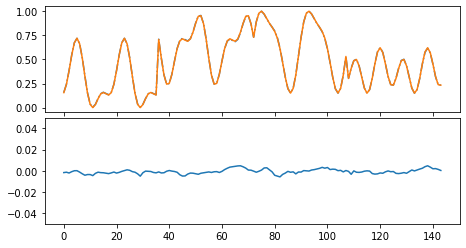

In [21]:
input_data = (ydata/norm).flatten(order='F')

input_parameters = np.array([225., 225., 315., 315.,    234.,125.26, 54.74, 305.26,   0.,45.,0.,0.,  1.,1.,1.,1.,   0.335,75.442,0.])
fix = np.array([1,1,1,1  ,1,1,1,1  ,1,1,0,0, 1.,1.,1.,1.  ,0,0,0])

pars, yfit, sigma, chi2 = pln.lm(ret_angle,input_data,input_parameters,pln.lm_pol_model,niter=20,chi2_stop = 1e-20,
    fix = fix,limits = np.array([0,0,360]) )

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(input_data,'-.')
ax1.plot(yfit,'-')
ax2.plot(yfit - input_data)
ax2.set_ylim([-0.05,0.05])

print('parameter:  ','  In:     ',' Out:')
params = ['s1','s2','s3','s4','p1','p2','p3','p4','ret1','ret2','pol','rot','t1','t2','t3','t4','alpha', 'delta', 'theta']
for i in range(len(pars)):
    print('{:<6s}{:<6s}{:>6.4f}{:<6s}{:>6.4f}'.format(params[i],': ',input_parameters[i],' ',pars[i]))


Iter:   0 Lambda:   1.0000e+01 chi2: 4.35e-03 better
Iter:   1 Lambda:   1.0000e+00 chi2: 3.46e-03 better
Iter:   2 Lambda:   1.0000e-01 chi2: 1.21e-03 better
Iter:   3 Lambda:   1.0000e-02 chi2: 2.24e-04 better
Iter:   4 Lambda:   1.0000e-03 chi2: 3.14e-05 better
Iter:   5 Lambda:   1.0000e-04 chi2: 8.23e-06 worse
Iter:   6 Lambda:   1.0000e-03 chi2: 8.23e-06 worse
Iter:   7 Lambda:   1.0000e-02 chi2: 8.23e-06 better
Iter:   8 Lambda:   1.0000e-03 chi2: 7.45e-06 worse
Iter:   9 Lambda:   1.0000e-02 chi2: 7.45e-06 worse
Iter:  10 Lambda:   1.0000e-01 chi2: 7.45e-06 better
Iter:  11 Lambda:   1.0000e-02 chi2: 6.74e-06 worse
Iter:  12 Lambda:   1.0000e-01 chi2: 6.74e-06 better
Iter:  13 Lambda:   1.0000e-02 chi2: 6.62e-06 worse
Iter:  14 Lambda:   1.0000e-01 chi2: 6.62e-06 better
Iter:  15 Lambda:   1.0000e-02 chi2: 6.59e-06 worse
Iter:  16 Lambda:   1.0000e-01 chi2: 6.59e-06 better
Iter:  17 Lambda:   1.0000e-02 chi2: 6.58e-06 worse
Iter:  18 Lambda:   1.0000e-01 chi2: 6.58e-06 better
I

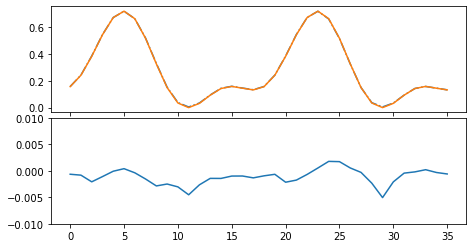

In [24]:
######################################################################################################################
input_parameters = np.array([225., 225., 315., 315., 234.,125.26, 54.74, 305.26,  0.,45.,0.,0.,  1.,1.,1.,1.,   0.335,75.442,0.])
input_data = (ydata[:,0]/norm).flatten(order='F')
fix = np.array([1,0,0,0  ,1,0,0,0  ,1,1,0,0, 1,0,0,0,  0,0,0])

pars, yfit, sigma, chi2 = pln.lm(ret_angle,input_data,input_parameters,pln.lm_pol_model,niter=20,chi2_stop = 1e-20,
    fix = fix,limits = np.array([0,0,360]), modulation = 0)

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(input_data,'-.')
ax1.plot(yfit,'-')
ax2.plot(yfit - input_data)
ax2.set_ylim([-0.01,0.01])

print('parameter:  ','  In:     ',' Out:')
params = ['s1','s2','s3','s4','p1','p2','p3','p4','ret1','ret2','pol','rot','t1','t2','t3','t4','alpha', 'delta', 'theta']
for i in range(len(pars)):
    print('{:<6s}{:<6s}{:>6.4f}{:<6s}{:>6.4f}'.format(params[i],': ',input_parameters[i],' ',pars[i]))

Iter:   0 Lambda:   1.0000e+01 chi2: 3.14e-01 better
Iter:   1 Lambda:   1.0000e+00 chi2: 2.81e-01 better
Iter:   2 Lambda:   1.0000e-01 chi2: 1.77e-01 better
Iter:   3 Lambda:   1.0000e-02 chi2: 1.00e-01 better
Iter:   4 Lambda:   1.0000e-03 chi2: 5.86e-02 better
Iter:   5 Lambda:   1.0000e-04 chi2: 3.04e-02 worse
Iter:   6 Lambda:   1.0000e-03 chi2: 3.04e-02 worse
Iter:   7 Lambda:   1.0000e-02 chi2: 3.04e-02 better
Iter:   8 Lambda:   1.0000e-03 chi2: 2.46e-02 better
Iter:   9 Lambda:   1.0000e-04 chi2: 8.08e-03 worse
Iter:  10 Lambda:   1.0000e-03 chi2: 8.08e-03 better
Iter:  11 Lambda:   1.0000e-04 chi2: 1.22e-03 better
Iter:  12 Lambda:   1.0000e-05 chi2: 1.57e-04 better
Iter:  13 Lambda:   1.0000e-06 chi2: 4.08e-05 worse
Iter:  14 Lambda:   1.0000e-05 chi2: 4.08e-05 worse
Iter:  15 Lambda:   1.0000e-04 chi2: 4.08e-05 better
Iter:  16 Lambda:   1.0000e-05 chi2: 1.80e-05 worse
Iter:  17 Lambda:   1.0000e-04 chi2: 1.80e-05 better
Iter:  18 Lambda:   1.0000e-05 chi2: 1.48e-05 worse


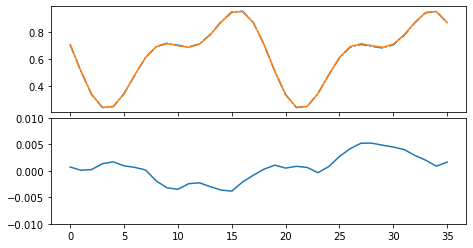

In [26]:
######################################################################################################################
input_parameters = np.array([225., 225., 315., 315., 234.,125.26, 54.74, 305.26,  0.,45.,0.,0.,  1.,1.,1.,1.,   0.335,75.442,0.])
input_data = (ydata[:,1]/norm).flatten(order='F')
fix = np.array([0,1,0,0  ,0,1,0,0  ,1,1,0,0, 0,1,0,0,  0,0,0])

pars, yfit, sigma, chi2 = pln.lm(ret_angle,input_data,input_parameters,pln.lm_pol_model,niter=20,chi2_stop = 1e-20,
    fix = fix,w_cut=1e-40,limits = np.array([0,0,360]), modulation = 1)

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(input_data,'-.')
ax1.plot(yfit,'-')
ax2.plot(yfit - input_data)
ax2.set_ylim([-0.01,0.01])

print('parameter:  ','  In:     ',' Out:')
params = ['s1','s2','s3','s4','p1','p2','p3','p4','ret1','ret2','pol','rot','t1','t2','t3','t4','alpha', 'delta', 'theta']
for i in range(len(pars)):
    print('{:<6s}{:<6s}{:>6.4f}{:<6s}{:>6.4f}'.format(params[i],': ',input_parameters[i],' ',pars[i]))

Iter:   0 Lambda:   1.0000e+01 chi2: 1.84e-02 better
Iter:   1 Lambda:   1.0000e+00 chi2: 1.35e-02 better
Iter:   2 Lambda:   1.0000e-01 chi2: 4.14e-03 better
Iter:   3 Lambda:   1.0000e-02 chi2: 6.70e-04 better
Iter:   4 Lambda:   1.0000e-03 chi2: 8.91e-05 better
Iter:   5 Lambda:   1.0000e-04 chi2: 2.00e-05 better
Iter:   6 Lambda:   1.0000e-05 chi2: 1.81e-05 worse
Iter:   7 Lambda:   1.0000e-04 chi2: 1.81e-05 worse
Iter:   8 Lambda:   1.0000e-03 chi2: 1.81e-05 better
Iter:   9 Lambda:   1.0000e-04 chi2: 1.08e-05 worse
Iter:  10 Lambda:   1.0000e-03 chi2: 1.08e-05 better
Iter:  11 Lambda:   1.0000e-04 chi2: 9.42e-06 worse
Iter:  12 Lambda:   1.0000e-03 chi2: 9.42e-06 better
Iter:  13 Lambda:   1.0000e-04 chi2: 9.10e-06 worse
Iter:  14 Lambda:   1.0000e-03 chi2: 9.10e-06 better
Iter:  15 Lambda:   1.0000e-04 chi2: 9.01e-06 worse
Iter:  16 Lambda:   1.0000e-03 chi2: 9.01e-06 better
Iter:  17 Lambda:   1.0000e-04 chi2: 8.96e-06 worse
Iter:  18 Lambda:   1.0000e-03 chi2: 8.96e-06 better


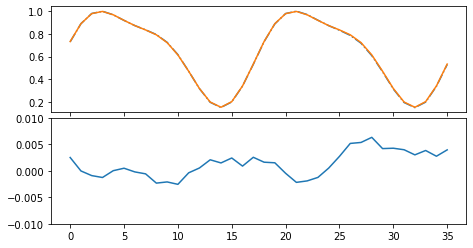

In [27]:
######################################################################################################################
input_parameters = np.array([225., 225., 315., 315., 234.,125.26, 54.74, 305.26,  0.,45.,0.,0.,  1.,1.,1.,1.,   0.335,75.442,0.])
input_data = (ydata[:,2]/norm).flatten(order='F')
fix = np.array([0,0,1,0  ,0,0,1,0  ,1,1,0,0, 0,0,1,0,  0,0,0])

pars, yfit, sigma, chi2 = pln.lm(ret_angle,input_data,input_parameters,pln.lm_pol_model,niter=20,chi2_stop = 1e-20,
    fix = fix,w_cut=1e-40,limits = np.array([0,0,360]), modulation = 2)

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(input_data,'-.')
ax1.plot(yfit,'-')
ax2.plot(yfit - input_data)
ax2.set_ylim([-0.01,0.01])

print('parameter:  ','  In:     ',' Out:')
params = ['s1','s2','s3','s4','p1','p2','p3','p4','ret1','ret2','pol','rot','t1','t2','t3','t4','alpha', 'delta', 'theta']
for i in range(len(pars)):
    print('{:<6s}{:<6s}{:>6.4f}{:<6s}{:>6.4f}'.format(params[i],': ',input_parameters[i],' ',pars[i]))

Iter:   0 Lambda:   1.0000e+01 chi2: 3.64e-01 better
Iter:   1 Lambda:   1.0000e+00 chi2: 3.17e-01 better
Iter:   2 Lambda:   1.0000e-01 chi2: 1.80e-01 better
Iter:   3 Lambda:   1.0000e-02 chi2: 8.64e-02 better
Iter:   4 Lambda:   1.0000e-03 chi2: 8.22e-02 worse
Iter:   5 Lambda:   1.0000e-02 chi2: 8.22e-02 worse
Iter:   6 Lambda:   1.0000e-01 chi2: 8.22e-02 worse
Iter:   7 Lambda:   1.0000e+00 chi2: 8.22e-02 better
Iter:   8 Lambda:   1.0000e-01 chi2: 5.71e-02 worse
Iter:   9 Lambda:   1.0000e+00 chi2: 5.71e-02 better
Iter:  10 Lambda:   1.0000e-01 chi2: 5.13e-02 worse
Iter:  11 Lambda:   1.0000e+00 chi2: 5.13e-02 better
Iter:  12 Lambda:   1.0000e-01 chi2: 4.09e-02 worse
Iter:  13 Lambda:   1.0000e+00 chi2: 4.09e-02 better
Iter:  14 Lambda:   1.0000e-01 chi2: 3.64e-02 better
Iter:  15 Lambda:   1.0000e-02 chi2: 2.04e-02 better
Iter:  16 Lambda:   1.0000e-03 chi2: 8.26e-03 better
Iter:  17 Lambda:   1.0000e-04 chi2: 1.30e-03 better
Iter:  18 Lambda:   1.0000e-05 chi2: 1.75e-04 better

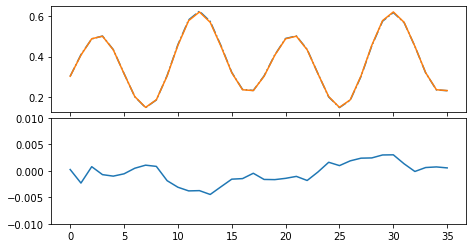

In [28]:
######################################################################################################################
input_parameters = np.array([225., 225., 315., 315., 234.,125.26, 54.74, 305.26,  0.,45.,0.,0.,  1.,1.,1.,1.,   0.335,75.442,0.])
input_data = (ydata[:,3]/norm).flatten(order='F')
fix = np.array([0,0,0,1  ,0,0,0,1  ,1,1,0,0, 0,0,0,1,  0,0,0])

pars, yfit, sigma, chi2 = pln.lm(ret_angle,input_data,input_parameters,pln.lm_pol_model,niter=20,chi2_stop = 1e-20,
    fix = fix,w_cut=1e-40,limits = np.array([0,0,360]), modulation = 3)

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(input_data,'-.')
ax1.plot(yfit,'-')
ax2.plot(yfit - input_data)
ax2.set_ylim([-0.01,0.01])

print('parameter:  ','  In:     ',' Out:')
params = ['s1','s2','s3','s4','p1','p2','p3','p4','ret1','ret2','pol','rot','t1','t2','t3','t4','alpha', 'delta', 'theta']
for i in range(len(pars)):
    print('{:<6s}{:<6s}{:>6.4f}{:<6s}{:>6.4f}'.format(params[i],': ',input_parameters[i],' ',pars[i]))